In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-10-13 19:42:13.224002: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
ind_pick_from_batch = [0, 1, 3, 4, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 22]
#ind_pick_32 = [0, 3, 4, 8, 9, 10, 13, 14, 17, 18, 21, 22]
L_vars = len(ind_pick_from_batch)
#L_vars_32 = len(ind_pick_32)

In [6]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*neg_neg_neg*lead4.npy"))

filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead2.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead3.npy")+\
                            glob("/glade/scratch/ksha/DATA/NCAR_batch/TRAIN*pos*lead4.npy"))

filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*lead2.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*lead2.npy"))

In [60]:
filename_valid = filename_neg_valid[::50] + filename_pos_valid

In [120]:
# Np = len(filename_pos_train)
# Nn = len(filename_neg_train)

# initial_bias = np.log([Np/Nn])

weight_for_0 = 0.3
weight_for_1 = 21.0

class_weight = {0: weight_for_0, 1: weight_for_1}


In [65]:
len(filename_valid)

5999

In [66]:
# with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
#     lon_3km = h5io['lon_3km'][...]
#     lat_3km = h5io['lat_3km'][...]
#     lon_72km = h5io['lon_72km'][...]
#     lat_72km = h5io['lat_72km'][...]
#     land_mask_72km = h5io['land_mask_72km'][...]
#     land_mask_3km = h5io['land_mask_3km'][...]

In [67]:
L_valid = len(filename_valid)

TEST_input_64 = np.empty((L_valid, 64, 64, L_vars))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    data = np.load(name)
    for k, c in enumerate(ind_pick_from_batch):
        
        TEST_input_64[i, ..., k] = data[..., c]

    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [68]:
np.sum(TEST_target) / len(TEST_target)

0.07251208534755793

**ConvNext**

In [69]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


In [123]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6


model_name='Branch64X'
input_shape=(64, 64, 15)
IN64 = layers.Input(shape=input_shape)
X = IN64

X = layers.LocallyConnected2D(64, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc1_norm".format(model_name))(X)
X = layers.Activation("gelu", name="{}_lc1_gelu".format(model_name))(X)

X = layers.LocallyConnected2D(96, kernel_size=1, strides=(1, 1), padding="valid", implementation=1)(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_lc2_norm".format(model_name))(X)
X = layers.Activation("gelu", name="{}_lc2_gelu".format(model_name))(X)

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[0], kernel_size=7, padding="same",
                               groups=projection_dims[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[0], 
                            name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[1], kernel_size=7, padding="same",
                               groups=projection_dims[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[1], 
                            name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[2], kernel_size=7, padding="same",
                               groups=projection_dims[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[2], 
                            name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, padding='same', name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dims[3], kernel_size=7, padding="same",
                               groups=projection_dims[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dims[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dims[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dims[3], 
                            name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

V1 = X

OUT1 = layers.GlobalMaxPooling2D(name="{}_head_pool64".format(model_name))(V1)
OUT1 = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm64".format(model_name))(OUT1)

OUT = OUT1

OUT = layers.Dense(128, name="{}_dense1".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_dense1_norm".format(model_name))(OUT)
OUT = layers.Activation("gelu", name="{}_dense1_gelu{}".format(model_name, j))(OUT)

OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN64, outputs=OUT, name=model_name)

In [86]:
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss


def verif_metric(VALID_target, Y_pred):


    # fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    # AUC = auc(fpr, tpr)
    # AUC_metric = 1 - AUC
    
    BS = np.mean((VALID_target.ravel() - Y_pred.ravel())**2)
    #ll = log_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{}'.format(BS))
    metric = BS

    return metric

In [124]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience

epochs = 500
L_train = 64
batch_size = 100

batch_size_half = 50

valid_size = 1

In [125]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'LC2_Lead2'

model_name = '{}_pp15'.format(key)
model_path = temp_dir+model_name

# W_old = k_utils.dummy_loader(temp_dir+'LC_Lead2_pp15_tune2')
# model.set_weights(W_old)


In [126]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-5))
#keras.losses.BinaryCrossentropy(from_logits=True)

In [127]:
X_batch_64 = np.empty((batch_size, 64, 64, L_vars))
Y_batch = np.empty((batch_size, 1))

X_batch_64[...] = np.nan
Y_batch[...] = np.nan

In [128]:
Y_pred = model.predict([TEST_input_64])

In [129]:
# save_dict = {}
# save_dict['y_true'] = TEST_target
# save_dict['y_pred'] = Y_pred

# np.save("ALL_pred_lead2.npy", save_dict)

In [130]:
# Y_pred[Y_pred<0] = 0
# Y_pred[Y_pred>1] = 1
record = verif_metric(TEST_target, Y_pred)
print("Initial record: {}".format(record))

0.7200767029768078
Initial record: 0.7200767029768078


In [131]:
# 0.03280427478163448
# Initial record: 0.03280427478163448

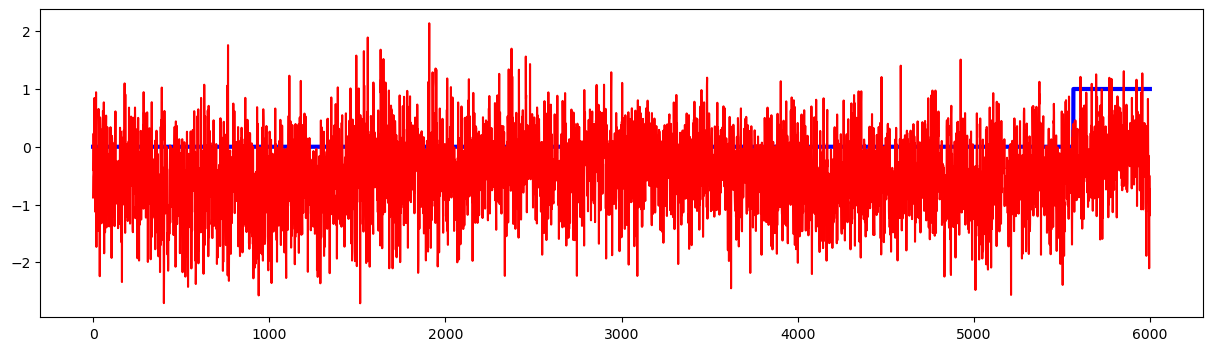

In [132]:
plt.figure(figsize=(15, 4))
plt.plot(TEST_target, 'b-', lw=3.0)
plt.plot(Y_pred, 'r-')
#plt.plot(Y_pred>0.5)

In [133]:
# plt.pcolormesh(TEST_input[3154, ..., 2], cmap=plt.cm.nipy_spectral_r)
# plt.colorbar()

In [134]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# ========== Training loop ========== #
L_storm = len(filename_neg_train)
L_aug = len(filename_pos_train)

for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        #N_aug = int(np.random.uniform(1, 4))
        N_aug = int(np.random.uniform(8, 14))
        #N_aug = int(np.random.uniform(10, 25))
        #N_aug = int(np.random.uniform(20, 45))
        
        N_storm = 100 - N_aug
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):

            data = np.load(file_pick[k])
            
            for l, c in enumerate(ind_pick_from_batch):
            
                X_batch_64[k, ..., l] = data[..., c]
            
            if 'pos' in file_pick[k]:
                Y_batch[k, :] = 1.0 #np.random.uniform(0.9, 0.99)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = 0.0 #np.random.uniform(0.01, 0.05)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch_64 = X_batch_64[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        # train on batch
        model.train_on_batch(X_batch_64, Y_batch);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input_64])
    # Y_pred[Y_pred<0] = 0
    # Y_pred[Y_pred>1] = 1
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

0.04650662634888884
Validation loss improved from 0.7200767029768078 to 0.04650662634888884
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 749.6672830581665 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.04262080360565255
Validation loss improved from 0.04650662634888884 to 0.04262080360565255
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 775.3205199241638 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.045622508949952525
Validation loss 0.045622508949952525 NOT improved
0.04098020814734447
Validation loss improved from 0.04262080360565255 to 0.04098020814734447
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 757.882488489151 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03744599838415329
Validation loss improved from 0.04098020814734447 to 0.03744599838415329
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 755.8437035083771 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03650352010005353
Validation loss improved from 0.03744599838415329 to 0.03650352010005353
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 777.4437394142151 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03617180816150641
Validation loss improved from 0.03650352010005353 to 0.03617180816150641
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 800.3747191429138 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03527268544187117
Validation loss improved from 0.03617180816150641 to 0.03527268544187117
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 768.7130990028381 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0375304980623352
Validation loss 0.0375304980623352 NOT improved
0.037665696391024295
Validation loss 0.037665696391024295 NOT improved
0.03635826660596175
Validation loss 0.03635826660596175 NOT improved
0.03625834258807918
Validation loss 0.03625834258807918 NOT improved
0.03469422478019098
Validation loss improved from 0.03527268544187117 to 0.03469422478019098
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 773.4951972961426 seconds ---


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.03592327760845828
Validation loss 0.03592327760845828 NOT improved
0.0353135415602159
Validation loss 0.0353135415602159 NOT improved
0.034132899066365706
Validation loss improved from 0.03469422478019098 to 0.034132899066365706
save to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15
INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/LC2_Lead2_pp15/assets
--- 764.4302990436554 seconds ---


In [38]:
j

123844

In [ ]:
https://mesonet.agron.iastate.edu/pickup/wwa/

In [29]:
10 % 3

1